# Análise do Campeonato Brasileiro 2025 com Apache Spark

Objetivo: analisar eventos de partidas simuladas do Campeonato Brasileiro 2025 usando Spark SQL, Structured Streaming e ML.

Dataset: dados sintéticos gerados neste notebook (20 times, 380 partidas, ~38.000 eventos).

Streaming de eventos: publicação em arquivos JSON (file sink) e leitura com Structured Streaming (trigger once).

Análises: agregações SQL, visualizações e clustering (times e jogadores) com Spark MLlib.


## 1. Configuração do Ambiente Spark

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkStandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import uuid
import time as _time
import warnings
import json
import os
import shutil
import builtins
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')
print("Imports e configuração de gráficos concluídos")

Imports e configuração de gráficos concluídos


In [2]:
spark = SparkSession.builder \
    .appName("CampeonatoBrasileiro2025") \
    .master("local[*]") \
    .config("spark.ui.enabled", "true") \
    .config("spark.ui.port", "4040") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")
print(f"Spark Session: {spark.version}")
print(f"App: {spark.sparkContext.appName}")
print(f"Master: {spark.sparkContext.master}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Spark Session: 3.4.1
App: CampeonatoBrasileiro2025
Master: local[*]
Spark UI: http://0d3ecf17ea82:4040


## 2. Geração de Dados do Campeonato Brasileiro 2025

In [3]:
# 20 times do Brasileirão 2025
times_brasileirao = [
    'Flamengo', 'Palmeiras', 'São Paulo', 'Corinthians', 'Santos', 'Vasco',
    'Botafogo', 'Fluminense', 'Atlético-MG', 'Cruzeiro', 'Internacional',
    'Grêmio', 'Bahia', 'Sport', 'Fortaleza', 'Ceará', 'Athletico-PR',
    'Coritiba', 'Goiás', 'Cuiabá'
]

# 30 tipos de eventos que acontecem em uma partida de futebol
tipos_eventos = [
    'GOL', 'ASSISTENCIA', 'CHUTE_GOL', 'CHUTE_FORA', 'CHUTE_DEFENDIDO',
    'PASSE_CERTO', 'PASSE_ERRADO', 'PASSE_LONGO', 'CRUZAMENTO',
    'FALTA_COMETIDA', 'FALTA_SOFRIDA', 'CARTAO_AMARELO', 'CARTAO_VERMELHO',
    'IMPEDIMENTO', 'ESCANTEIO', 'LATERAL', 'TIRO_META', 'PENALTI',
    'DEFESA_GOLEIRO', 'DESARME', 'INTERCEPTACAO', 'CABECADA',
    'DRIBLE_CERTO', 'DRIBLE_ERRADO', 'SUBSTITUICAO', 'LESAO',
    'COBRANCA_FALTA', 'COBRANCA_ESCANTEIO', 'COBRANCA_PENALTI', 'POSSE_BOLA'
]

print(f"Times participantes: {len(times_brasileirao)}")
print(f"Tipos de eventos: {len(tipos_eventos)}")
print(f"Times: {', '.join(times_brasileirao[:5])}...")

Times participantes: 20
Tipos de eventos: 30
Times: Flamengo, Palmeiras, São Paulo, Corinthians, Santos...


## 3. Geração de Jogadores (11 por time)

In [4]:
# Gerar jogadores para cada time (11 jogadores por time)
jogadores_por_time = {}
nomes_jogadores = [
    'Silva', 'Santos', 'Oliveira', 'Souza', 'Lima', 'Pereira', 'Costa', 'Rodrigues',
    'Almeida', 'Nascimento', 'Carvalho', 'Araújo', 'Melo', 'Barbosa', 'Ribeiro',
    'Martins', 'Rocha', 'Ferreira', 'Gomes', 'Dias', 'Moreira', 'Cardoso', 'Reis',
    'Fernandes', 'Castro', 'Andrade', 'Machado', 'Freitas', 'Monteiro', 'Campos',
    'Vieira', 'Ramos', 'Correia', 'Teixeira', 'Mendes', 'Nunes', 'Soares', 'Lopes',
    'Pinto', 'Cunha', 'Fonseca', 'Morais', 'Batista', 'Guerreiro', 'Coelho'
]

for time in times_brasileirao:
    # Gerar 11 jogadores únicos por time
    nomes_time = random.sample(nomes_jogadores, 11)
    jogadores_por_time[time] = [f"{nome} {i+1}" for i, nome in enumerate(nomes_time)]

total_jogadores = len(times_brasileirao) * 11  # 20 times x 11 jogadores cada
print(f"Jogadores gerados: {len(jogadores_por_time)} times x 11 jogadores = {total_jogadores} jogadores")

# Mostrar exemplo de jogadores
print(f"\nExemplo - Jogadores do Flamengo:")
for i, jogador in enumerate(jogadores_por_time['Flamengo'][:5]):
    print(f"   {i+1}. {jogador}")
print("   ...")

Jogadores gerados: 20 times x 11 jogadores = 220 jogadores

Exemplo - Jogadores do Flamengo:
   1. Soares 1
   2. Ribeiro 2
   3. Barbosa 3
   4. Nascimento 4
   5. Monteiro 5
   ...


## 4. Geração de Partidas (38 rodadas sem repetição)

In [5]:
# Gerar todas as partidas do campeonato (38 rodadas)
# Cada time joga contra todos os outros 2 vezes (casa e fora)
partidas = []

# Gerar todas as combinações possíveis
todas_combinacoes = []
for i, time_casa in enumerate(times_brasileirao):
    for j, time_visitante in enumerate(times_brasileirao):
        if i != j:  # Time não joga contra si mesmo
            todas_combinacoes.append((time_casa, time_visitante))

# Embaralhar as combinações
random.shuffle(todas_combinacoes)

# Distribuir em 38 rodadas (10 jogos por rodada)
rodada = 1
for i in range(0, len(todas_combinacoes), 10):
    jogos_rodada = todas_combinacoes[i:i+10]
    
    # Determinar se é turno ou returno
    turno = 'Primeiro' if rodada <= 19 else 'Segundo'
    
    for time_casa, time_visitante in jogos_rodada:
        partidas.append({
            'rodada': rodada,
            'turno': turno,
            'time_casa': time_casa,
            'time_visitante': time_visitante,
            'data': datetime(2025, 5, 1) + timedelta(days=(rodada-1)*7)
        })
    
    rodada += 1
    if rodada > 38:  # Limitar a 38 rodadas
        break

print(f"Partidas geradas: {len(partidas)} jogos")
print(f"Período: {partidas[0]['data'].strftime('%d/%m/%Y')} a {partidas[-1]['data'].strftime('%d/%m/%Y')}")
print(f"Rodadas: {builtins.max(p['rodada'] for p in partidas)}")

Partidas geradas: 380 jogos
Período: 01/05/2025 a 15/01/2026
Rodadas: 38


## 3. Publicação de Eventos (File Sink)

In [6]:
# Função para gerar eventos de futebol
def gerar_evento_futebol(partida, jogadores_por_time, tipos_eventos):
    """Gera um evento de futebol para uma partida"""
    # Escolher time (60% casa, 40% visitante)
    if random.random() < 0.6:
        time = partida['time_casa']
    else:
        time = partida['time_visitante']
    
    # Escolher jogador do time
    jogador = random.choice(jogadores_por_time[time])
    
    # Tipo de evento (alguns mais frequentes que outros)
    if random.random() < 0.4:
        tipo_evento = random.choice(['PASSE_CERTO', 'PASSE_ERRADO', 'POSSE_BOLA'])
    elif random.random() < 0.6:
        tipo_evento = random.choice(['CHUTE_FORA', 'FALTA_COMETIDA', 'DESARME'])
    elif random.random() < 0.7:
        tipo_evento = random.choice(['ESCANTEIO', 'LATERAL', 'TIRO_META'])
    else:
        tipo_evento = random.choice(tipos_eventos)
    
    # Minuto da partida
    minuto = random.randint(1, 90)
    
    # Timestamp atual
    timestamp = datetime.now()
    
    evento = {
        'id': str(uuid.uuid4())[:8],
        'rodada': partida['rodada'],
        'turno': partida['turno'],
        'time_casa': partida['time_casa'],
        'time_visitante': partida['time_visitante'],
        'time_evento': time,
        'jogador': jogador,
        'tipo_evento': tipo_evento,
        'minuto': minuto,
        'timestamp': timestamp.isoformat(),
        'data_partida': partida['data'].strftime('%Y-%m-%d')
    }
    
    return json.dumps(evento)

print("Função de geração de eventos configurada")

Função de geração de eventos configurada


In [7]:
INBOX_DIR = 'data/stream_inbox'
CKPT_DIR = 'data/stream_ckpt'
if os.path.exists(INBOX_DIR):
    shutil.rmtree(INBOX_DIR)
os.makedirs(INBOX_DIR, exist_ok=True)
if os.path.exists(CKPT_DIR):
    shutil.rmtree(CKPT_DIR)
os.makedirs(CKPT_DIR, exist_ok=True)
eventos_publicacao = []
for partida in partidas:
    for _ in range(100):
        evento_json = gerar_evento_futebol(partida, jogadores_por_time, tipos_eventos)
        eventos_publicacao.append(json.loads(evento_json))
df_publicacao = spark.createDataFrame(eventos_publicacao)
df_publicacao.coalesce(1).write.mode('overwrite').json(INBOX_DIR)
print(f"Eventos publicados em {INBOX_DIR}: {df_publicacao.count():,}")

Eventos publicados em data/stream_inbox: 38,000


## 4. Leitura dos Eventos (Structured Streaming, trigger once)

In [8]:
evento_schema = T.StructType([
    T.StructField('id', T.StringType(), True),
    T.StructField('rodada', T.IntegerType(), True),
    T.StructField('turno', T.StringType(), True),
    T.StructField('time_casa', T.StringType(), True),
    T.StructField('time_visitante', T.StringType(), True),
    T.StructField('time_evento', T.StringType(), True),
    T.StructField('jogador', T.StringType(), True),
    T.StructField('tipo_evento', T.StringType(), True),
    T.StructField('minuto', T.IntegerType(), True),
    T.StructField('timestamp', T.StringType(), True),
    T.StructField('data_partida', T.StringType(), True),
])
df_stream = spark.readStream.schema(evento_schema).json(INBOX_DIR)
for q in spark.streams.active:
    if q.name == 'eventos':
        q.stop()
query = df_stream.writeStream.outputMode('append').format('memory').queryName('eventos').option('checkpointLocation', CKPT_DIR).trigger(once=True).start()
query.awaitTermination()
total_eventos = spark.sql("SELECT COUNT(*) AS c FROM eventos").collect()[0]['c']
print(f"Eventos lidos do inbox: {total_eventos:,}")

Eventos lidos do inbox: 38,000


## 7. Análises SQL com Spark

In [9]:
# Garantir que a view 'eventos' exista vinda do Structured Streaming
print('Verificando view eventos...')
import time as _time
for _ in range(60):
    try:
        total = spark.sql("SELECT COUNT(*) AS c FROM eventos").collect()[0]['c']
        print(f"View 'eventos' disponível. Registros: {total:,}")
        break
    except Exception:
        _time.sleep(1)
else:
    raise RuntimeError("View 'eventos' não foi criada pelo streaming")

Verificando view eventos...
View 'eventos' disponível. Registros: 38,000


In [10]:
# Análises SQL com Spark
print("=== ANÁLISES SQL COM SPARK ===")

# 1. Estatísticas por time
print("\n1. TOP 5 TIMES - GOLS MARCADOS:")
gols_por_time = spark.sql("""
    SELECT time_evento, COUNT(*) as gols_marcados
    FROM eventos 
    WHERE tipo_evento = 'GOL'
    GROUP BY time_evento
    ORDER BY gols_marcados DESC
    LIMIT 5
""")
gols_por_time.show()

# 2. Passes certos por time
print("\n2. TOP 5 TIMES - PASSES CERTOS:")
passes_por_time = spark.sql("""
    SELECT time_evento, COUNT(*) as passes_certos
    FROM eventos 
    WHERE tipo_evento = 'PASSE_CERTO'
    GROUP BY time_evento
    ORDER BY passes_certos DESC
    LIMIT 5
""")
passes_por_time.show()

# 3. Tipos de eventos mais frequentes
print("\n4. TOP 10 TIPOS DE EVENTOS:")
tipos_eventos_freq = spark.sql("""
    SELECT tipo_evento, COUNT(*) as frequencia
    FROM eventos
    GROUP BY tipo_evento
    ORDER BY frequencia DESC
    LIMIT 10
""")
tipos_eventos_freq.show()

# 4. artilheiros
print("\n5. TOP 10 ARTILHEIROS:")
artilheiros = spark.sql("""
    SELECT jogador, time_evento, COUNT(*) as gols
    FROM eventos
    WHERE tipo_evento = 'GOL'
    GROUP BY jogador, time_evento
    ORDER BY gols DESC
    LIMIT 10
""")
artilheiros.show()

=== ANÁLISES SQL COM SPARK ===

1. TOP 5 TIMES - GOLS MARCADOS:
+-----------+-------------+
|time_evento|gols_marcados|
+-----------+-------------+
|Corinthians|            8|
|     Santos|            7|
|      Vasco|            6|
|      Bahia|            6|
|  Fortaleza|            5|
+-----------+-------------+


2. TOP 5 TIMES - PASSES CERTOS:
+------------+-------------+
| time_evento|passes_certos|
+------------+-------------+
|       Bahia|          270|
|    Botafogo|          269|
|Athletico-PR|          269|
|       Ceará|          266|
| Atlético-MG|          264|
+------------+-------------+


4. TOP 10 TIPOS DE EVENTOS:
+--------------+----------+
|   tipo_evento|frequencia|
+--------------+----------+
|    POSSE_BOLA|      5213|
|  PASSE_ERRADO|      5151|
|   PASSE_CERTO|      5051|
|       DESARME|      4713|
|    CHUTE_FORA|      4693|
|FALTA_COMETIDA|      4587|
|     ESCANTEIO|      2324|
|     TIRO_META|      2190|
|       LATERAL|      2170|
|       PENALTI|       

## 8. Visualizações do Campeonato

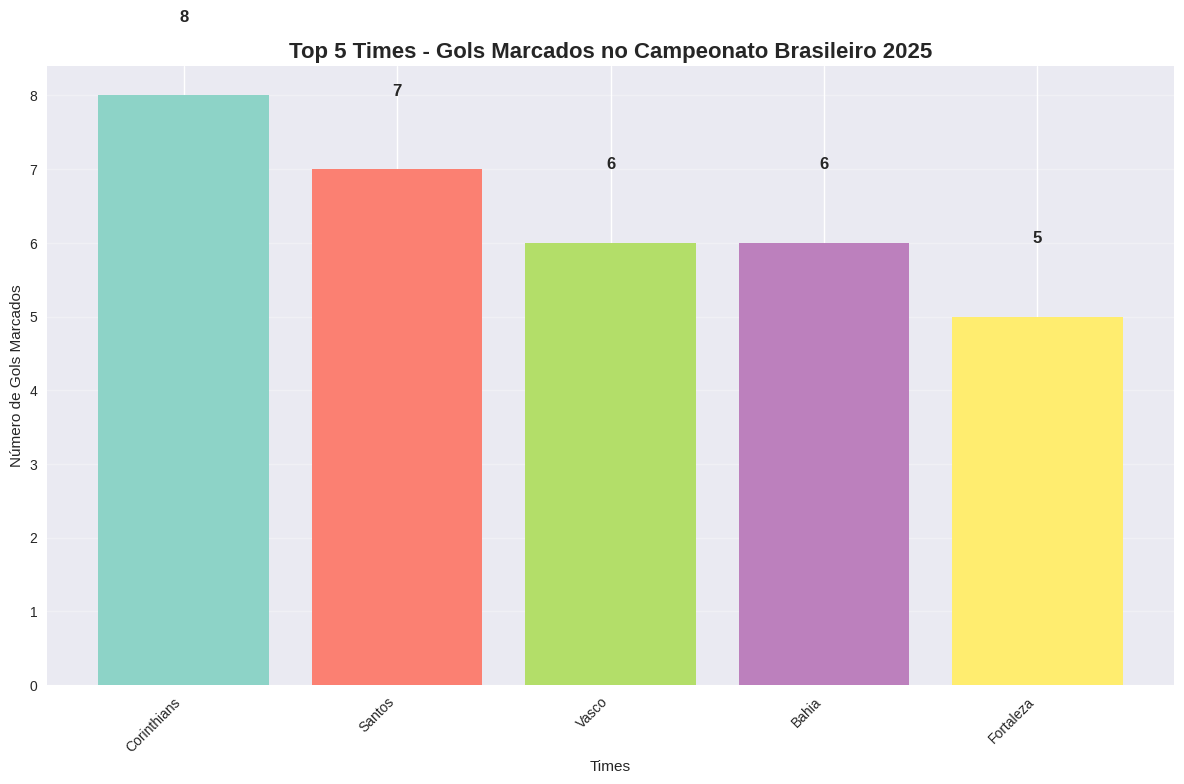

Gráfico 1: Top 5 Times - Gols Marcados


In [11]:
try:
    stats_por_time
except NameError:
    stats_por_time = spark.sql("SELECT time_evento, SUM(CASE WHEN tipo_evento='GOL' THEN 1 ELSE 0 END) AS gols_marcados, SUM(CASE WHEN tipo_evento='PASSE_CERTO' THEN 1 ELSE 0 END) AS passes_certos, SUM(CASE WHEN tipo_evento LIKE '%CHUTE%' THEN 1 ELSE 0 END) AS chutes, SUM(CASE WHEN tipo_evento='FALTA_COMETIDA' THEN 1 ELSE 0 END) AS faltas, SUM(CASE WHEN tipo_evento='PENALTI' THEN 1 ELSE 0 END) AS penaltis, COUNT(*) AS total_eventos FROM eventos GROUP BY time_evento").toPandas().set_index('time_evento')
# Configurar estilo dos gráficos
sns.set_palette("husl")

# 1. Gráfico: Top 5 Times - Gols Marcados
plt.figure(figsize=(12, 8))
top_5_gols = stats_por_time.nlargest(5, 'gols_marcados')
colors = plt.cm.Set3(np.linspace(0, 1, len(top_5_gols)))
bars = plt.bar(top_5_gols.index, top_5_gols['gols_marcados'], color=colors)
plt.title('Top 5 Times - Gols Marcados no Campeonato Brasileiro 2025', fontsize=16, fontweight='bold')
plt.ylabel('Número de Gols Marcados')
plt.xlabel('Times')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(top_5_gols['gols_marcados']):
    plt.text(i, v + 1, str(int(v)), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
print("Gráfico 1: Top 5 Times - Gols Marcados")

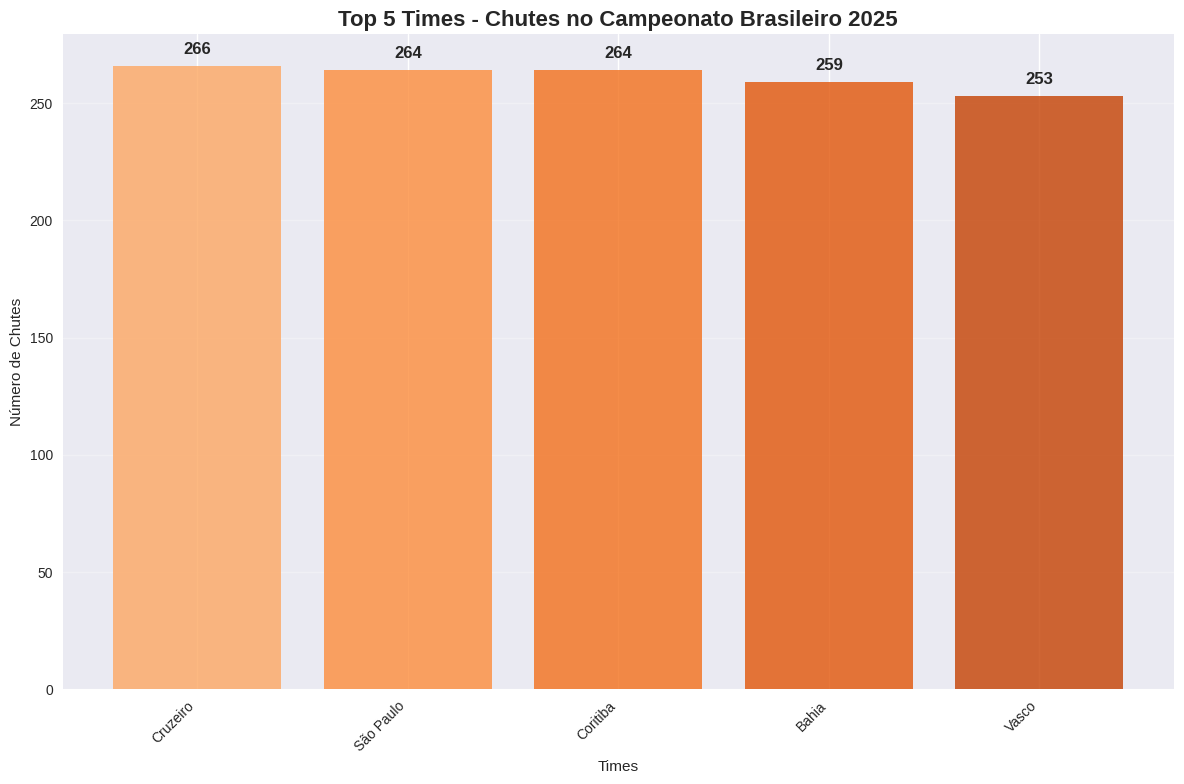

Gráfico 2: Top 5 Times - Chutes


In [12]:
# 2. Gráfico: Top 5 Times - Chutes
plt.figure(figsize=(12, 8))
top_5_chutes = stats_por_time.nlargest(5, 'chutes')
colors = plt.cm.Oranges(np.linspace(0.4, 0.8, len(top_5_chutes)))
plt.bar(top_5_chutes.index, top_5_chutes['chutes'], color=colors, alpha=0.8)
plt.title('Top 5 Times - Chutes no Campeonato Brasileiro 2025', fontsize=16, fontweight='bold')
plt.ylabel('Número de Chutes')
plt.xlabel('Times')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(top_5_chutes['chutes']):
    plt.text(i, v + 5, str(int(v)), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
print("Gráfico 2: Top 5 Times - Chutes")

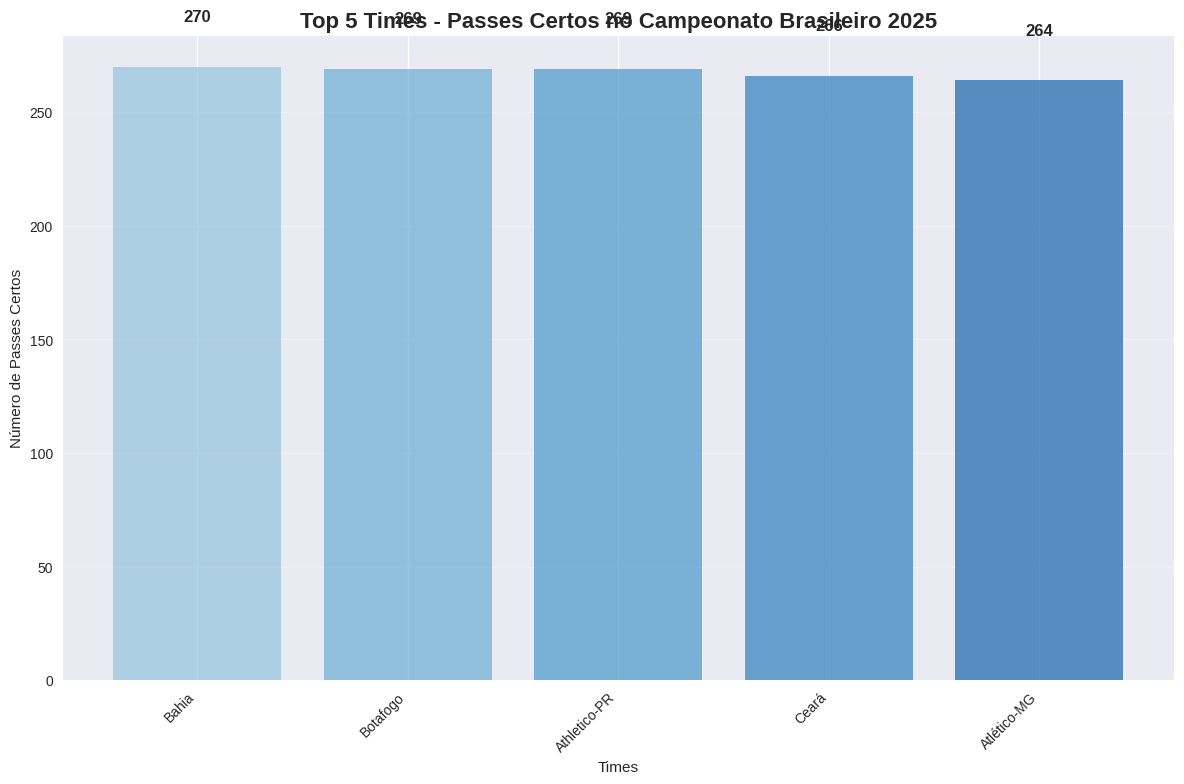

Gráfico 3: Top 5 Times - Passes Certos


In [13]:
# 3. Gráfico: Top 5 Times - Passes Certos
plt.figure(figsize=(12, 8))
top_5_passes = stats_por_time.nlargest(5, 'passes_certos')
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(top_5_passes)))
plt.bar(top_5_passes.index, top_5_passes['passes_certos'], color=colors, alpha=0.7)
plt.title('Top 5 Times - Passes Certos no Campeonato Brasileiro 2025', fontsize=16, fontweight='bold')
plt.ylabel('Número de Passes Certos')
plt.xlabel('Times')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(top_5_passes['passes_certos']):
    plt.text(i, v + 20, str(int(v)), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
print("Gráfico 3: Top 5 Times - Passes Certos")

## 8. Machine Learning - Clustering de Times

In [14]:
# Preparar dados para clustering de times usando Spark SQL
print("Preparando dados para clustering de times com Spark MLlib...")

# Calcular estatísticas por time usando Spark SQL
stats_times_spark = spark.sql("""
    SELECT 
        time_evento,
        SUM(CASE WHEN tipo_evento = 'GOL' THEN 1 ELSE 0 END) as gols_marcados,
        SUM(CASE WHEN tipo_evento = 'ASSISTENCIA' THEN 1 ELSE 0 END) as assistencias,
        SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END) as passes_certos,
        SUM(CASE WHEN tipo_evento = 'PASSE_ERRADO' THEN 1 ELSE 0 END) as passes_errados,
        SUM(CASE WHEN tipo_evento = 'PASSE_LONGO' THEN 1 ELSE 0 END) as passes_longos,
        SUM(CASE WHEN tipo_evento = 'CRUZAMENTO' THEN 1 ELSE 0 END) as cruzamentos,
        SUM(CASE WHEN tipo_evento = 'CHUTE_GOL' THEN 1 ELSE 0 END) as chutes_gol,
        SUM(CASE WHEN tipo_evento = 'CHUTE_FORA' THEN 1 ELSE 0 END) as chutes_fora,
        SUM(CASE WHEN tipo_evento = 'CHUTE_DEFENDIDO' THEN 1 ELSE 0 END) as chutes_defendidos,
        SUM(CASE WHEN tipo_evento = 'FALTA_COMETIDA' THEN 1 ELSE 0 END) as faltas_cometidas,
        SUM(CASE WHEN tipo_evento = 'FALTA_SOFRIDA' THEN 1 ELSE 0 END) as faltas_sofridas,
        SUM(CASE WHEN tipo_evento = 'CARTAO_AMARELO' THEN 1 ELSE 0 END) as cartoes_amarelos,
        SUM(CASE WHEN tipo_evento = 'CARTAO_VERMELHO' THEN 1 ELSE 0 END) as cartoes_vermelhos,
        SUM(CASE WHEN tipo_evento = 'IMPEDIMENTO' THEN 1 ELSE 0 END) as impedimentos,
        SUM(CASE WHEN tipo_evento = 'ESCANTEIO' THEN 1 ELSE 0 END) as escanteios,
        SUM(CASE WHEN tipo_evento = 'LATERAL' THEN 1 ELSE 0 END) as laterais,
        SUM(CASE WHEN tipo_evento = 'TIRO_META' THEN 1 ELSE 0 END) as tiros_meta,
        SUM(CASE WHEN tipo_evento = 'PENALTI' THEN 1 ELSE 0 END) as penaltis,
        SUM(CASE WHEN tipo_evento = 'DEFESA_GOLEIRO' THEN 1 ELSE 0 END) as defesas_goleiro,
        SUM(CASE WHEN tipo_evento = 'DESARME' THEN 1 ELSE 0 END) as desarmes,
        SUM(CASE WHEN tipo_evento = 'INTERCEPTACAO' THEN 1 ELSE 0 END) as interceptacoes,
        SUM(CASE WHEN tipo_evento = 'CABECADA' THEN 1 ELSE 0 END) as cabecadas,
        SUM(CASE WHEN tipo_evento = 'DRIBLE_CERTO' THEN 1 ELSE 0 END) as dribles_certos,
        SUM(CASE WHEN tipo_evento = 'DRIBLE_ERRADO' THEN 1 ELSE 0 END) as dribles_errados,
        SUM(CASE WHEN tipo_evento = 'COBRANCA_FALTA' THEN 1 ELSE 0 END) as cobrancas_falta,
        SUM(CASE WHEN tipo_evento = 'COBRANCA_ESCANTEIO' THEN 1 ELSE 0 END) as cobrancas_escanteio,
        SUM(CASE WHEN tipo_evento = 'COBRANCA_PENALTI' THEN 1 ELSE 0 END) as cobrancas_penalti,
        SUM(CASE WHEN tipo_evento = 'POSSE_BOLA' THEN 1 ELSE 0 END) as posse_bola,
        COUNT(*) as total_eventos,
        CASE WHEN (SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END)+SUM(CASE WHEN tipo_evento = 'PASSE_ERRADO' THEN 1 ELSE 0 END)) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END) AS DOUBLE) / (SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END)+SUM(CASE WHEN tipo_evento = 'PASSE_ERRADO' THEN 1 ELSE 0 END)) ELSE 0.0 END as taxa_acerto_passe,
        CASE WHEN (SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END)) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'CHUTE_GOL' THEN 1 ELSE 0 END) AS DOUBLE) / SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END) ELSE 0.0 END as taxa_chute_no_alvo,
        CASE WHEN (SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END)) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'GOL' THEN 1 ELSE 0 END) AS DOUBLE) / SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END) ELSE 0.0 END as taxa_conversao_chute,
        CASE WHEN COUNT(*) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'FALTA_COMETIDA' THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) ELSE 0.0 END as proporcao_faltas,
        CASE WHEN COUNT(*) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'POSSE_BOLA' THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) ELSE 0.0 END as proporcao_posse
    FROM eventos
    GROUP BY time_evento
    ORDER BY time_evento
""")

# Preparar features para clustering
assembler = VectorAssembler(
    inputCols=["gols_marcados", "assistencias", "passes_certos", "passes_errados", "passes_longos", "cruzamentos", "chutes_gol", "chutes_fora", "chutes_defendidos", "faltas_cometidas", "faltas_sofridas", "cartoes_amarelos", "cartoes_vermelhos", "impedimentos", "escanteios", "laterais", "tiros_meta", "penaltis", "defesas_goleiro", "desarmes", "interceptacoes", "cabecadas", "dribles_certos", "dribles_errados", "cobrancas_falta", "cobrancas_escanteio", "cobrancas_penalti", "posse_bola", "total_eventos", "taxa_acerto_passe", "taxa_chute_no_alvo", "taxa_conversao_chute", "proporcao_faltas", "proporcao_posse"],
    outputCol="features_raw"
)

# Normalizar features
scaler = SparkStandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Configurar K-Means
kmeans = SparkKMeans(
    featuresCol="features",
    predictionCol="cluster",
    k=5,
    seed=42
)

# Criar pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Treinar modelo
print("Treinando modelo de clustering com Spark MLlib...")
modelo_clustering = pipeline.fit(stats_times_spark)

# Aplicar clustering
resultados_clustering = modelo_clustering.transform(stats_times_spark)
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster")
silhouette_times = evaluator.evaluate(resultados_clustering)
print(f"Silhouette (times): {silhouette_times:.4f}")

print("\nResultados do clustering de times:")
resultados_clustering.select("time_evento", "gols_marcados", "passes_certos", "faltas_cometidas", "penaltis", "cluster").show()

Preparando dados para clustering de times com Spark MLlib...
Treinando modelo de clustering com Spark MLlib...
Silhouette (times): 0.1200

Resultados do clustering de times:
+-------------+-------------+-------------+----------------+--------+-------+
|  time_evento|gols_marcados|passes_certos|faltas_cometidas|penaltis|cluster|
+-------------+-------------+-------------+----------------+--------+-------+
| Athletico-PR|            4|          269|             244|       3|      0|
|  Atlético-MG|            4|          264|             214|       8|      4|
|        Bahia|            6|          270|             191|       6|      4|
|     Botafogo|            1|          269|             203|       9|      2|
|        Ceará|            5|          266|             218|       3|      4|
|  Corinthians|            8|          264|             257|       4|      3|
|     Coritiba|            2|          253|             251|      11|      3|
|     Cruzeiro|            2|          249|   

In [15]:
# Analisar clusters de times
print("\nAnálise dos clusters de times:")
resultados_clustering.createOrReplaceTempView("resultados_clustering_view")
clusters_analysis = spark.sql("""
    SELECT 
        cluster,
        COUNT(*) as num_times,
        ROUND(AVG(gols_marcados), 2) as avg_gols,
        ROUND(AVG(passes_certos), 2) as avg_passes,
        ROUND(AVG(faltas), 2) as avg_faltas,
        ROUND(AVG(penaltis), 2) as avg_penaltis,
        COLLECT_LIST(time_evento) as times
    FROM (
        SELECT time_evento, gols_marcados, passes_certos, faltas_cometidas as faltas, penaltis, cluster
        FROM resultados_clustering_view
    )
    GROUP BY cluster
    ORDER BY cluster
""")

# Registrar resultados como view temporária
resultados_clustering.createOrReplaceTempView("resultados_clustering_view")

clusters_analysis.show(truncate=False)


Análise dos clusters de times:
+-------+---------+--------+----------+----------+------------+-----------------------------------------------------------------------+
|cluster|num_times|avg_gols|avg_passes|avg_faltas|avg_penaltis|times                                                                  |
+-------+---------+--------+----------+----------+------------+-----------------------------------------------------------------------+
|0      |5        |4.2     |254.4     |229.4     |5.0         |[Athletico-PR, Cruzeiro, Grêmio, Santos, São Paulo]                    |
|1      |2        |3.5     |215.0     |238.5     |5.0         |[Cuiabá, Flamengo]                                                     |
|2      |2        |1.0     |263.5     |218.0     |6.5         |[Botafogo, Fluminense]                                                 |
|3      |4        |3.5     |252.75    |250.25    |6.5         |[Corinthians, Coritiba, Goiás, Sport]                                  |
|4      |7      

## 10. Machine Learning - Clustering de Jogadores

In [16]:
# Preparar dados para clustering de jogadores usando Spark SQL
print("Preparando dados para clustering de jogadores com Spark MLlib...")

# Calcular estatísticas por jogador usando Spark SQL
stats_jogadores_spark = spark.sql("""
    SELECT 
        jogador,
        time_evento,
        COUNT(*) as total_eventos,
        SUM(CASE WHEN tipo_evento = 'GOL' THEN 1 ELSE 0 END) as gols,
        SUM(CASE WHEN tipo_evento = 'ASSISTENCIA' THEN 1 ELSE 0 END) as assistencias,
        SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END) as passes_certos,
        SUM(CASE WHEN tipo_evento = 'PASSE_ERRADO' THEN 1 ELSE 0 END) as passes_errados,
        SUM(CASE WHEN tipo_evento = 'PASSE_LONGO' THEN 1 ELSE 0 END) as passes_longos,
        SUM(CASE WHEN tipo_evento = 'CRUZAMENTO' THEN 1 ELSE 0 END) as cruzamentos,
        SUM(CASE WHEN tipo_evento = 'CHUTE_GOL' THEN 1 ELSE 0 END) as chutes_gol,
        SUM(CASE WHEN tipo_evento = 'CHUTE_FORA' THEN 1 ELSE 0 END) as chutes_fora,
        SUM(CASE WHEN tipo_evento = 'CHUTE_DEFENDIDO' THEN 1 ELSE 0 END) as chutes_defendidos,
        SUM(CASE WHEN tipo_evento = 'FALTA_COMETIDA' THEN 1 ELSE 0 END) as faltas_cometidas,
        SUM(CASE WHEN tipo_evento = 'FALTA_SOFRIDA' THEN 1 ELSE 0 END) as faltas_sofridas,
        SUM(CASE WHEN tipo_evento = 'CARTAO_AMARELO' THEN 1 ELSE 0 END) as cartoes_amarelos,
        SUM(CASE WHEN tipo_evento = 'CARTAO_VERMELHO' THEN 1 ELSE 0 END) as cartoes_vermelhos,
        SUM(CASE WHEN tipo_evento = 'IMPEDIMENTO' THEN 1 ELSE 0 END) as impedimentos,
        SUM(CASE WHEN tipo_evento = 'ESCANTEIO' THEN 1 ELSE 0 END) as escanteios,
        SUM(CASE WHEN tipo_evento = 'LATERAL' THEN 1 ELSE 0 END) as laterais,
        SUM(CASE WHEN tipo_evento = 'TIRO_META' THEN 1 ELSE 0 END) as tiros_meta,
        SUM(CASE WHEN tipo_evento = 'PENALTI' THEN 1 ELSE 0 END) as penaltis,
        SUM(CASE WHEN tipo_evento = 'DEFESA_GOLEIRO' THEN 1 ELSE 0 END) as defesas_goleiro,
        SUM(CASE WHEN tipo_evento = 'DESARME' THEN 1 ELSE 0 END) as desarmes,
        SUM(CASE WHEN tipo_evento = 'INTERCEPTACAO' THEN 1 ELSE 0 END) as interceptacoes,
        SUM(CASE WHEN tipo_evento = 'CABECADA' THEN 1 ELSE 0 END) as cabecadas,
        SUM(CASE WHEN tipo_evento = 'DRIBLE_CERTO' THEN 1 ELSE 0 END) as dribles_certos,
        SUM(CASE WHEN tipo_evento = 'DRIBLE_ERRADO' THEN 1 ELSE 0 END) as dribles_errados,
        SUM(CASE WHEN tipo_evento = 'COBRANCA_FALTA' THEN 1 ELSE 0 END) as cobrancas_falta,
        SUM(CASE WHEN tipo_evento = 'COBRANCA_ESCANTEIO' THEN 1 ELSE 0 END) as cobrancas_escanteio,
        SUM(CASE WHEN tipo_evento = 'COBRANCA_PENALTI' THEN 1 ELSE 0 END) as cobrancas_penalti,
        SUM(CASE WHEN tipo_evento = 'POSSE_BOLA' THEN 1 ELSE 0 END) as posse_bola,
        CASE WHEN (SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END)+SUM(CASE WHEN tipo_evento = 'PASSE_ERRADO' THEN 1 ELSE 0 END)) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END) AS DOUBLE) / (SUM(CASE WHEN tipo_evento = 'PASSE_CERTO' THEN 1 ELSE 0 END)+SUM(CASE WHEN tipo_evento = 'PASSE_ERRADO' THEN 1 ELSE 0 END)) ELSE 0.0 END as taxa_acerto_passe,
        CASE WHEN (SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END)) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'CHUTE_GOL' THEN 1 ELSE 0 END) AS DOUBLE) / SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END) ELSE 0.0 END as taxa_chute_no_alvo,
        CASE WHEN (SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END)) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'GOL' THEN 1 ELSE 0 END) AS DOUBLE) / SUM(CASE WHEN tipo_evento IN ('CHUTE_GOL','CHUTE_FORA','CHUTE_DEFENDIDO') THEN 1 ELSE 0 END) ELSE 0.0 END as taxa_conversao_chute,
        CASE WHEN COUNT(*) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'FALTA_COMETIDA' THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) ELSE 0.0 END as proporcao_faltas,
        CASE WHEN COUNT(*) > 0 THEN CAST(SUM(CASE WHEN tipo_evento = 'POSSE_BOLA' THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) ELSE 0.0 END as proporcao_posse
    FROM eventos
    GROUP BY jogador, time_evento
    ORDER BY total_eventos DESC
""")

# Preparar features para clustering de jogadores
assembler_jogadores = VectorAssembler(
    inputCols=["total_eventos", "gols", "assistencias", "passes_certos", "passes_errados", "passes_longos", "cruzamentos", "chutes_gol", "chutes_fora", "chutes_defendidos", "faltas_cometidas", "faltas_sofridas", "cartoes_amarelos", "cartoes_vermelhos", "impedimentos", "escanteios", "laterais", "tiros_meta", "penaltis", "defesas_goleiro", "desarmes", "interceptacoes", "cabecadas", "dribles_certos", "dribles_errados", "cobrancas_falta", "cobrancas_escanteio", "cobrancas_penalti", "posse_bola", "taxa_acerto_passe", "taxa_chute_no_alvo", "taxa_conversao_chute", "proporcao_faltas", "proporcao_posse"],
    outputCol="features_raw"
)

# Normalizar features
scaler_jogadores = SparkStandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Configurar K-Means para jogadores
kmeans_jogadores = SparkKMeans(
    featuresCol="features",
    predictionCol="cluster",
    k=5,
    seed=42
)

# Criar pipeline para jogadores
pipeline_jogadores = Pipeline(stages=[assembler_jogadores, scaler_jogadores, kmeans_jogadores])

# Treinar modelo
print("Treinando modelo de clustering para jogadores...")
modelo_clustering_jogadores = pipeline_jogadores.fit(stats_jogadores_spark)

# Aplicar clustering
resultados_clustering_jogadores = modelo_clustering_jogadores.transform(stats_jogadores_spark)
evaluator_jog = ClusteringEvaluator(featuresCol="features", predictionCol="cluster")
silhouette_jogadores = evaluator_jog.evaluate(resultados_clustering_jogadores)
print(f"Silhouette (jogadores): {silhouette_jogadores:.4f}")

print("\nResultados do clustering de jogadores (top 15):")
resultados_clustering_jogadores.select("jogador", "time_evento", "total_eventos", "gols", "passes_certos", "cluster").show(15)

Preparando dados para clustering de jogadores com Spark MLlib...
Treinando modelo de clustering para jogadores...
Silhouette (jogadores): 0.0789

Resultados do clustering de jogadores (top 15):
+----------+-------------+-------------+----+-------------+-------+
|   jogador|  time_evento|total_eventos|gols|passes_certos|cluster|
+----------+-------------+-------------+----+-------------+-------+
|  Vieira 7|  Corinthians|          208|   1|           25|      0|
|Oliveira 1|       Grêmio|          201|   0|           33|      1|
|   Ramos 5|        Goiás|          200|   0|           24|      1|
|Teixeira 1|        Sport|          197|   0|           23|      0|
|  Castro 1|    São Paulo|          197|   1|           24|      0|
| Ribeiro 4|Internacional|          197|   1|           21|      0|
|  Castro 5|Internacional|          195|   0|           25|      1|
|  Rocha 11|        Goiás|          194|   1|           32|      0|
| Fonseca 7|    Fortaleza|          194|   2|           25

In [17]:
# Analisar clusters de jogadores
print("\nAnálise dos clusters de jogadores:")
resultados_clustering_jogadores.createOrReplaceTempView("jogadores_clusters_view")

clusters_jogadores_analysis = spark.sql("""
    SELECT 
        cluster,
        COUNT(*) as num_jogadores,
        ROUND(AVG(total_eventos), 2) as avg_eventos,
        ROUND(AVG(gols), 2) as avg_gols,
        ROUND(AVG(passes_certos), 2) as avg_passes,
        ROUND(AVG(chutes_gol + chutes_fora + chutes_defendidos), 2) as avg_chutes,
        ROUND(AVG(faltas_cometidas), 2) as avg_faltas
    FROM jogadores_clusters_view
    GROUP BY cluster
    ORDER BY cluster
""")

clusters_jogadores_analysis.show()


Análise dos clusters de jogadores:
+-------+-------------+-----------+--------+----------+----------+----------+
|cluster|num_jogadores|avg_eventos|avg_gols|avg_passes|avg_chutes|avg_faltas|
+-------+-------------+-----------+--------+----------+----------+----------+
|      0|           60|     180.18|    0.25|     22.42|     21.67|     22.23|
|      1|           48|     177.54|    0.17|     25.71|     24.46|     24.71|
|      2|           59|     167.15|    0.05|     22.86|     20.46|     17.53|
|      3|           40|     165.95|    0.83|     20.85|     23.75|     18.95|
|      4|           13|     166.69|    1.62|     22.23|     18.23|     21.15|
+-------+-------------+-----------+--------+----------+----------+----------+



## 11. Resumo Final e Conclusões

In [18]:
print("=== RESUMO FINAL - CAMPEONATO BRASILEIRO 2025 ===")
print("Apache Spark com Streaming e Machine Learning")
print("-" * 55)

# Estatísticas finais usando Spark SQL
total_eventos = spark.sql("SELECT COUNT(*) as total FROM eventos").collect()[0]['total']
total_gols = spark.sql("SELECT COUNT(*) as gols FROM eventos WHERE tipo_evento = 'GOL'").collect()[0]['gols']
total_times = spark.sql("SELECT COUNT(DISTINCT time_evento) as times FROM eventos").collect()[0]['times']
total_jogadores = spark.sql("SELECT COUNT(DISTINCT jogador) as jogadores FROM eventos").collect()[0]['jogadores']

print(f"\nESTATÍSTICAS GERAIS:")
print(f"   Total de eventos processados via Spark Streaming: {total_eventos:,}")
print(f"   Total de gols: {total_gols}")
print(f"   Total de times: {total_times}")
print(f"   Total de jogadores: {total_jogadores}")
print(f"   Tipos de eventos: {len(tipos_eventos)}")

times_summary = spark.sql("SELECT cluster, AVG(gols_marcados) avg_gols, AVG(passes_certos) avg_passes, AVG(faltas_cometidas) avg_faltas, AVG(penaltis) avg_penaltis, COUNT(*) num_times FROM resultados_clustering_view GROUP BY cluster").toPandas()
if not times_summary.empty:
    c_gols = int(times_summary.loc[times_summary['avg_gols'].idxmax(), 'cluster'])
    v_gols = float(times_summary['avg_gols'].max())
    c_passes = int(times_summary.loc[times_summary['avg_passes'].idxmax(), 'cluster'])
    v_passes = float(times_summary['avg_passes'].max())
    c_faltas = int(times_summary.loc[times_summary['avg_faltas'].idxmax(), 'cluster'])
    v_faltas = float(times_summary['avg_faltas'].max())
    c_penaltis = int(times_summary.loc[times_summary['avg_penaltis'].idxmax(), 'cluster'])
    v_penaltis = float(times_summary['avg_penaltis'].max())
    print("\nRESUMO CLUSTERS (TIMES):")
    print(f"   • Cluster {c_gols}: maior média de gols ({v_gols:.2f}) — perfil ofensivo")
    print(f"   • Cluster {c_passes}: maior média de passes certos ({v_passes:.2f}) — controle de posse")
    print(f"   • Cluster {c_faltas}: maior média de faltas ({v_faltas:.2f}) — jogo físico")
    print(f"   • Cluster {c_penaltis}: mais pênaltis ({v_penaltis:.2f}) — presença na área")

jog_summary = spark.sql("SELECT cluster, AVG(total_eventos) avg_eventos, AVG(gols) avg_gols, AVG(passes_certos) avg_passes, AVG(chutes_gol + chutes_fora + chutes_defendidos) avg_chutes, AVG(faltas_cometidas) avg_faltas, COUNT(*) num_jog FROM jogadores_clusters_view GROUP BY cluster").toPandas()
if not jog_summary.empty:
    cj_gols = int(jog_summary.loc[jog_summary['avg_gols'].idxmax(), 'cluster'])
    vj_gols = float(jog_summary['avg_gols'].max())
    cj_passes = int(jog_summary.loc[jog_summary['avg_passes'].idxmax(), 'cluster'])
    vj_passes = float(jog_summary['avg_passes'].max())
    cj_chutes = int(jog_summary.loc[jog_summary['avg_chutes'].idxmax(), 'cluster'])
    vj_chutes = float(jog_summary['avg_chutes'].max())
    cj_faltas = int(jog_summary.loc[jog_summary['avg_faltas'].idxmax(), 'cluster'])
    vj_faltas = float(jog_summary['avg_faltas'].max())
    print("\nRESUMO CLUSTERS (JOGADORES):")
    print(f"   • Cluster {cj_gols}: maior média de gols ({vj_gols:.2f}) — finalizadores")
    print(f"   • Cluster {cj_passes}: maior média de passes ({vj_passes:.2f}) — construtores")
    print(f"   • Cluster {cj_chutes}: maior média de chutes ({vj_chutes:.2f}) — alta atividade ofensiva")
    print(f"   • Cluster {cj_faltas}: maior média de faltas ({vj_faltas:.2f}) — maior contato/pressão")
print("=" * 60)

=== RESUMO FINAL - CAMPEONATO BRASILEIRO 2025 ===
Apache Spark com Streaming e Machine Learning
-------------------------------------------------------

ESTATÍSTICAS GERAIS:
   Total de eventos processados via Spark Streaming: 38,000
   Total de gols: 80
   Total de times: 20
   Total de jogadores: 188
   Tipos de eventos: 30

RESUMO CLUSTERS (TIMES):
   • Cluster 4: maior média de gols (5.14) — perfil ofensivo
   • Cluster 2: maior média de passes certos (263.50) — controle de posse
   • Cluster 3: maior média de faltas (250.25) — jogo físico
   • Cluster 3: mais pênaltis (6.50) — presença na área

RESUMO CLUSTERS (JOGADORES):
   • Cluster 4: maior média de gols (1.62) — finalizadores
   • Cluster 1: maior média de passes (25.71) — construtores
   • Cluster 1: maior média de chutes (24.46) — alta atividade ofensiva
   • Cluster 1: maior média de faltas (24.71) — maior contato/pressão


In [19]:
# Finalizar Spark Session (desativado temporariamente para testes do Spark UI)
# spark.stop()
print("Spark Session finalizada (não encerrada).")

Spark Session finalizada (não encerrada).
